# Libraries

In [2]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
import numpy as np
import pandas
import seaborn as sns
import warnings
import time
from ipywidgets import FloatProgress
from IPython.display import display, Markdown, Latex

## Debugging Flags

In [3]:
debug_rounds = False
debug_matches = False

## Functions

In [4]:
def d20():
    return np.random.randint(1,21)

def do_match_and_update(a,b,rounds,df):
    wins = do_match(a,b,rounds)
    a_wins = wins[0]
    b_wins = wins[1]
    turns = wins[2]
    a_id = a[0]
    b_id = b[0]
    df.at[a_id,'round_wins'] = df.at[a_id,'round_wins'] + a_wins
    df.at[b_id,'round_wins'] = df.at[b_id,'round_wins'] + b_wins
    if a_wins > b_wins:
        df.at[a_id,'match_wins'] = df.at[a_id,'match_wins'] + 1
    else:
        df.at[b_id,'match_wins'] = df.at[b_id,'match_wins'] + 1
    return [df,turns]

def calc_match_and_update(a,b,df):
    wins = calc_match(a,b)
    a_wins = wins[0]
    b_wins = wins[1]
    a_id = a[0]
    b_id = b[0]
    if a_wins > b_wins:
        df.at[a_id,'calc_wins'] = df.at[a_id,'calc_wins'] + 1
    else:
        df.at[b_id,'calc_wins'] = df.at[b_id,'calc_wins'] + 1
    return df

def do_match(a,b,rounds):
    a_wins = 0
    b_wins = 0
    turns = 0
    for _ in np.arange(rounds):
        wins = do_round(a,b)
        a_wins = a_wins + wins[0]
        b_wins = b_wins + wins[1]
        turns = turns + wins[2]
    if debug_matches:
        print ("After %d rounds %s won %d times and %s won %d times" % (rounds,a.name,a_wins,b.name,b_wins))
    return [a_wins,b_wins,turns]

def calc_match(a,b):
    a_prob_hit_turn = (20 - b.ac) * 0.05
    if (a_prob_hit_turn > .95):
        a_prob_hit_turn = .95
    if (a_prob_hit_turn < 0.05):
        a_prob_hit_turn = 0.05
    a_avg_dam_max = a.dam_avg * a.att_num
    a_avg_dam_per_turn = a_prob_hit_turn * a_avg_dam_max
    a_turns_towin = np.ceil(b.hp / a_avg_dam_per_turn)
    b_prob_hit_turn = (20 - a.ac) * 0.05
    if (b_prob_hit_turn > .95):
        b_prob_hit_turn = .95
    if (b_prob_hit_turn < 0.05):
        b_prob_hit_turn = 0.05
    b_avg_dam_max = b.dam_avg * b.att_num
    b_avg_dam_per_turn = b_prob_hit_turn * b.dam_avg
    b_turns_towin = np.ceil(a.hp / b_avg_dam_per_turn)
    if a_turns_towin == b_turns_towin:
        if a.init >= b.init:
            return [1,0]
        else:
            return [0,1]
    else:
        if a_turns_towin < b_turns_towin:
            return [1,0]
        else:
            return [0,1]
    """Something went wrong here, nobody wins"""
    return [0,0]

def do_round( a, b ):
    a_init = d20() + a.init
    if debug_rounds:
        print("%s rolled %d init" % (a.name,a_init))
    b_init = d20() + b.init
    if debug_rounds:
        print("%s rolled %d init" % (b.name,b_init))
    if (a_init >= b_init):
        first = a.copy()
        second = b.copy()
        in_order = True
    else:
        first = b.copy()
        second = a.copy()
        in_order = False
    round = 0
    while (first.hp > 0 and second.hp > 0):
        if debug_rounds:
            print("    Round %d: %s hp is %d and %s hp is %d" % (round+1, first.name,first.hp,second.name,second.hp))
        round = round + 1
        first,second = do_attack(first,second)
        if (second.hp <= 0):
            if debug_rounds:
                print("%s is dead" % second.name)
            if in_order:
                return [1,0,round] #a went first and won
            else:
                return [0,1,round] #b went first and won
        else:
            second,first = do_attack(second,first)
            if (first.hp <= 0):
                if debug_rounds:
                    print("%s is dead" % first.name)
                if in_order:
                    return [0,1,round] #b went second and won
                else:
                    return [1,0,round] #a went second and won
    """Something went wrong here, nobody wins"""
    return [0,0]
    
def do_attack( attacker, target ):
    if debug_rounds:
        print ("        %s makes %d attacks against %s" % (attacker.name, attacker.att_num, target.name))
    for _ in np.arange(attacker.att_num):
        attack = d20() + attacker.hit_mod
        if (attack != 1 and (attack == 20 or attack >= target.ac)):
            target.hp = target.hp - attacker.dam_avg
            if debug_rounds:
                print("            %s hits %s for %d damage" % (attacker.name, target.name, attacker.dam_avg ))
        else:
            if debug_rounds:
                print("            %s misses %s" % (attacker.name, target.name))
    return [attacker, target]

def run_matches(creatures,rounds,name="creatures"):
    start = time.time()
    
    rows = creatures.shape[0]
    creatures['match_wins'] = np.zeros(rows)
    creatures['round_wins'] = np.zeros(rows)
    creatures['calc_wins'] = np.zeros(rows)

    matches = ((rows-1)**2 + rows - 1)/2 #nth triangular number for n-1

    f = FloatProgress(min=0, max=matches, description="Contest: ")
    display(f)

    turns = 0
    print("Performing %d matches of %d rounds each" % (matches,rounds))
    for i in np.arange(rows):
        a = creatures.take([i]).to_records()[0]
        for j in np.arange(i+1,rows):
            b = creatures.take([j]).to_records()[0]
            creatures,new_turns = do_match_and_update(a,b,rounds,creatures)
            turns = turns + new_turns
            creatures = calc_match_and_update(a,b,creatures)
            f.value = f.value + 1
    
    filename = "data/gen/%s_%02d.csv" % (name,rounds)
    creatures.to_csv(filename)
    
    end = time.time()
    seconds = round(end-start)
    print("Completed %d turns in %d seconds" % (turns,seconds))

def creature_from_party(df):
    """name,cr,ac,hp,init,att_num,hit_mod,dam_avg"""
    rows = df.shape[0]
    df2 = pandas.DataFrame()
    df2['name'] =  [ "Party of %d" % rows ]
    df2['cr'] = [ np.floor(df['cr'].sum()) ]
    df2['ac'] = [ np.floor(df['ac'].mean()) ]
    df2['hp'] = [ np.floor(df['hp'].sum()) ]
    df2['init'] = [ round(df['init'].mean(),2) ]
    df2['att_num'] = [ np.floor(df['att_num'].sum()) ]
    df2['hit_mod'] = [ np.floor(df['hit_mod'].mean()) ]
    df2['dam_avg'] = [ np.floor(df['dam_avg'].mean()) ]
    return df2
    
def gen_init(amount):
    """Generate initiative modifiers in range -5,5 with normal distribution"""
    s = np.round(np.random.normal(0, 1.66, amount),2)
    p = pandas.DataFrame(data=s)
    p = p[p[0].between(-5, 5, inclusive=True)]
    return p

def gen_ac(amount):
    return np.random.randint(13,20,amount)

def gen_hp(amount):
    return np.random.randint(10,810,amount)

def gen_att_num(amount):
    return np.random.randint(1,6,amount)

def gen_hit_mod(amount):
    return np.random.randint(3,15,amount)

def gen_dam_avg(amount):
    return np.random.randint(2,62,amount)

def create_randoms(size):
    """name,cr,ac,hp,init,att_num,hit_mod,dam_avg"""
    randoms = pandas.DataFrame()
    randoms['name'] = np.repeat([''],size)
    randoms['cr'] = np.zeros(size)
    randoms['ac'] = gen_ac(size)
    randoms['hp'] = gen_hp(size)
    randoms['init'] = gen_init(size)
    randoms['att_num'] = gen_att_num(size)
    randoms['hit_mod'] = gen_hit_mod(size)
    randoms['dam_avg'] = gen_dam_avg(size)
    return randoms

def create_cr_averages(creatures):
    creatures_avg = creatures.groupby('cr').mean().apply(np.round).astype(int).reset_index()
    creatures_avg['name'] = creatures_avg['cr']
    return creatures_avg

def plot_correl(file,col,logx=False,order=1,subtitle=''):
    df = pandas.read_csv(file)
    return plot_correl_df(df,col,logx=logx,order=order,subtitle=subtitle)

def plot_correl_df(df,col,logx=False,order=1,subtitle=''):
    rows = df.shape[0]
    df['percent_wins'] = df['match_wins'] / (rows-1)
    max_col = df.loc[df[col].idxmax()][col]
    df['percent_' + col] = df[col] / max_col
    df = df.sort_values(['percent_wins'],ascending=False)
    warnings.filterwarnings('ignore')
    r = np.corrcoef(df['percent_'+col],df['percent_wins'])[0][1]
    if len(subtitle) > 0:
        display(Markdown('### Correlation between %s and wins: %s' % (col,subtitle)))
    else:
        display(Markdown('### Correlation between %s and wins' % col))
    if 'type' in df.columns:
        plt = sns.lmplot( x='percent_'+col, y='percent_wins', data=df, fit_reg=False, hue='type', legend=True)
    else:
        if np.absolute(r) < 0.3:
            df.plot.scatter('percent_' + col,'percent_wins')
        else:
            sns.regplot(df['percent_'+col],df['percent_wins'],logx=logx,order=order)
    display(Markdown("r=%2f" % r))

## Correlation Between Combat Success and Attributes
In this experiment, we randomly generate a matrix of creature attributes and run a contest to determine the success rate of each combination. Examining the correaltion between each randomly-generated attribute and resulting success rate gives us an indication of its influence over combat success in context with the other attributes involved in the fundamental mechanic of melee combat.

In [59]:
randoms = create_randoms(100)
run_matches(randoms,100,'randoms')

FloatProgress(value=0.0, description='Contest: ', max=4950.0)

Performing 4950 matches of 100 rounds each
Completed 4738854 turns in 1381 seconds


### Correlation between ac and wins: randomly-generated creatures

r=0.082355

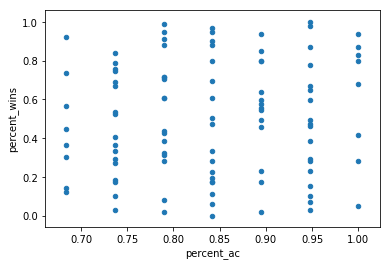

In [60]:
plot_correl('data/gen/randoms_100.csv','ac',subtitle='randomly-generated creatures')

### Correlation between init and wins: randomly-generated creatures

r=0.022104

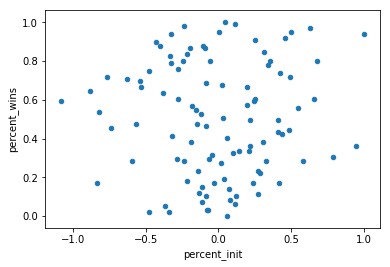

In [61]:
plot_correl('data/gen/randoms_100.csv','init',subtitle='randomly-generated creatures')

### Correlation between hit_mod and wins: randomly-generated creatures

r=0.082725

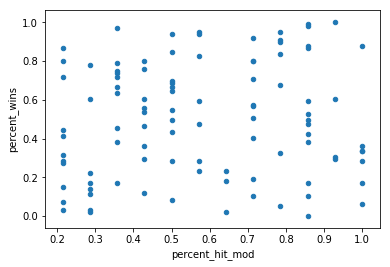

In [62]:
plot_correl('data/gen/randoms_100.csv','hit_mod',subtitle='randomly-generated creatures')

### Correlation between att_num and wins: randomly-generated creatures

r=0.420236

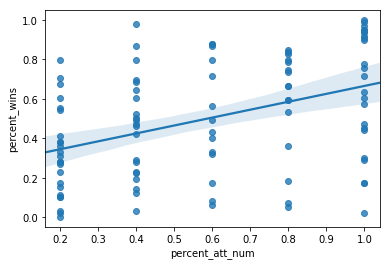

In [63]:
plot_correl('data/gen/randoms_100.csv','att_num',subtitle='randomly-generated creatures')

### Correlation between dam_avg and wins: randomly-generated creatures

r=0.483598

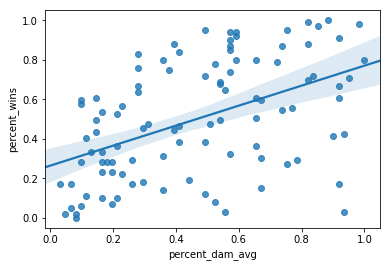

In [64]:
plot_correl('data/gen/randoms_100.csv','dam_avg',subtitle='randomly-generated creatures')

### Correlation between dam_max and wins: randomly-generated creatures

r=0.575844

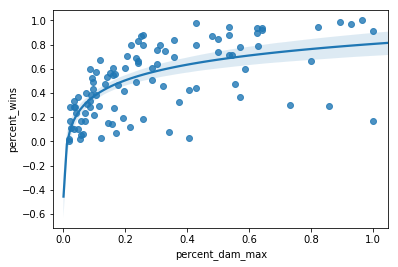

In [50]:
randoms = pandas.read_csv('data/gen/randoms_100.csv')
randoms['dam_max'] = randoms['dam_avg'] * randoms['att_num']
plot_correl_df(randoms,'dam_max',logx=True,subtitle='randomly-generated creatures')

### Correlation between hp and wins: randomly-generated creatures

r=0.569423

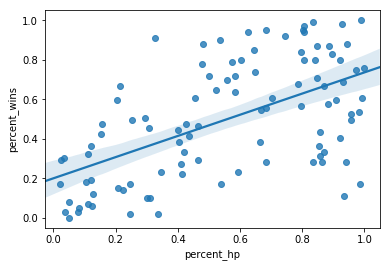

In [66]:
plot_correl('data/gen/randoms_100.csv','hp',subtitle='randomly-generated creatures')

### Correlation between hp_dam and wins: randomly-generated creatures

r=0.932661

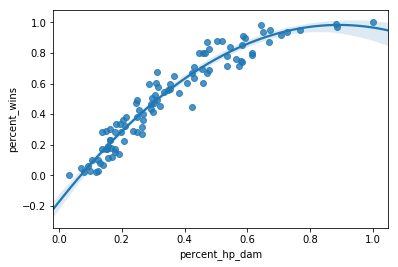

In [43]:
randoms = pandas.read_csv('data/gen/randoms_100.csv')
randoms['dam_max'] = randoms['dam_avg'] * randoms['att_num']
randoms['hp_dam'] = np.sqrt(randoms['dam_max'] * randoms['hp'])
plot_correl_df(randoms,'hp_dam',order=2,subtitle='randomly-generated creatures')

## Generic Characters and Creatures
In this experiment, we generate characters and creatures by level or challenge rating (respectively) using published guidelines, and run contests for each type of individual creature or party to ensure a strong correlation between challenge rating and combat success rate and even distribution/progression for that type.

### Generic Creatures
These creatures were generated using an interpretation of the guidelines on p. 274 of Dungeon Master's Guide (Wizards of the Coast, December 2014) in attempt to simulate a "typical" creature of each challenge rating from 0.125 - 30.

In [68]:
generics = pandas.read_csv('data/src/generics.csv')
run_matches(generics,100,'generics')

FloatProgress(value=0.0, description='Contest: ', max=528.0)

Performing 528 matches of 100 rounds each
Completed 132224 turns in 37 seconds


### Correlation between cr and wins: single monster

r=0.999187

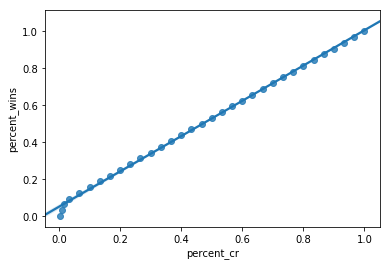

In [69]:
plot_correl('data/gen/generics_100.csv','cr',subtitle='single monster')

### Generic Party of Four Fighters
The level of a party of four characters is meant to correspond to the challenge rating of a comparable single creature, or the sum of challenge ratings of a group of creatures. The human fighter is [overwhelmingly the most popular character type](https://fivethirtyeight.com/features/is-your-dd-character-rare/), and arguably one of the most effective in melee combat. Here we assemble a party of four generic human fighters using an interpretation of the guidelines on pp. 70-75 of the Player's Handbook (Wizards of the Coast, August 2014). We exclude all but the most basic elements of character progress in relation to `hp`, `ac`, `att_num`, and `dam_avg`, assuming some upgrade in armour and ability score improvements (strength and constitution) as described.

In [70]:
fighters = pandas.read_csv('data/src/fighters.csv')
run_matches(fighters,100,'fighters')

FloatProgress(value=0.0, description='Contest: ', max=190.0)

Performing 190 matches of 100 rounds each
Completed 100132 turns in 60 seconds


### Correlation between cr and wins: party of 4 fighters

r=1.000000

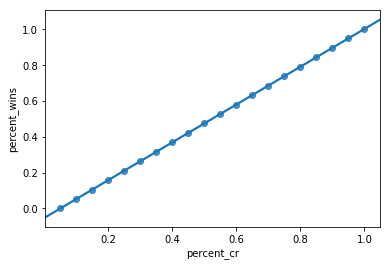

In [71]:
plot_correl('data/gen/fighters_100.csv','cr',subtitle='party of 4 fighters')

### Generic Party of Four Wizards
The elven wizard is [popular character type](https://fivethirtyeight.com/features/is-your-dd-character-rare/) that relies on spellcasting to make powerful attacks, and is generally amongst the most weak in melee combat. Here we assemble a party of four generic elven wizards using an interpretation of the guidelines on pp. 112-119 of the Player's Handbook (Wizards of the Coast, August 2014). In order to simulate a more accurate wizard, we allow this character to cast the shocking grasp cantrip, a melee attack spell whose attack modifier and damage output will progress as the character progresses. We exclude all but the most basic elements of character progress in relation to `hp`, `ac`, `att_num`, and `dam_avg`, assuming ability score improvements (intelligence and constitution) as described.

In [7]:
wizards = pandas.read_csv('data/src/wizards.csv')
run_matches(wizards,100,'wizards')

FloatProgress(value=0.0, description='Contest: ', max=190.0)

Performing 190 matches of 100 rounds each
Completed 58682 turns in 17 seconds


### Correlation between cr and wins: party of 4 wizards

r=0.995489

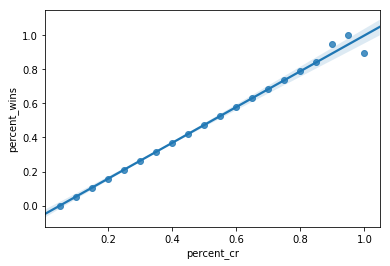

In [8]:
plot_correl('data/gen/wizards_100.csv','cr',subtitle='party of 4 wizards')

### Many Weaker Monsters
Since there is some positive correlation between number of attacks and combat effectiveness, here we assemble a group of between 1 and 30 monsters with a challenge rating of 1. This provides a linear increase in number of attacks far beyond that of a single typical CR 30 monster.

In [72]:
generics_to30 = pandas.read_csv('data/src/generics_to30.csv')
run_matches(generics_to30,100,'generics_to30')

FloatProgress(value=0.0, description='Contest: ', max=435.0)

Performing 435 matches of 100 rounds each
Completed 446681 turns in 378 seconds


### Correlation between cr and wins: 1-30 CR 1 monster(s)

r=1.000000

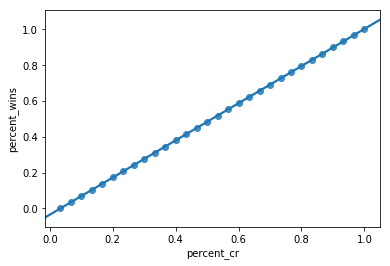

In [73]:
plot_correl('data/gen/generics_to30_100.csv','cr',subtitle='1-30 CR 1 monster(s)')

## Contests Between Characters and Creatures
### Party Characters versus Single Monster
Next, we run a contest between our party of four fighters, our party of four wizards, and our single monsters

In [13]:
fighters = pandas.read_csv('data/src/fighters.csv')
fighters['type'] = 'party of 4 fighters'
wizards = pandas.read_csv('data/src/wizards.csv')
wizards['type'] = 'party of 4 wizards'
generics = pandas.read_csv('data/src/generics.csv')
generics['type'] = 'single monster'
mixed = generics.append(fighters).append(wizards)
mixed = mixed.reset_index(drop=True)
run_matches(mixed,100,'characters_monster')

FloatProgress(value=0.0, description='Contest: ', max=2628.0)

Performing 2628 matches of 100 rounds each
Completed 820577 turns in 315 seconds


### Correlation between cr and wins: party of 4 characters and single generic monsters

r=0.920837

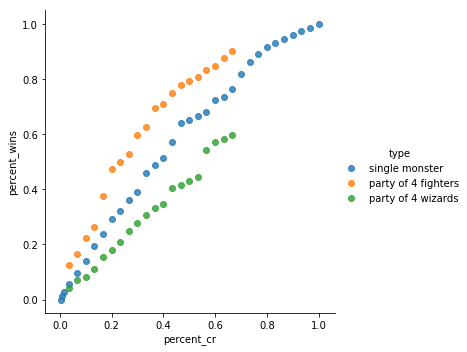

In [14]:
plot_correl('data/gen/characters_monster_100.csv','cr',subtitle='party of 4 characters and single generic monsters')

### Party of Characters versus Many Weaker Monsters
We then run a contest between our party of four fighers, party of four wizards, and 1-30 CR 1 monsters

In [15]:
fighters = pandas.read_csv('data/src/fighters.csv')
fighters['type'] = 'party of 4 fighters'
wizards = pandas.read_csv('data/src/wizards.csv')
wizards['type'] = 'party of 4 wizards'
generics_to30 = pandas.read_csv('data/src/generics_to30.csv')
generics_to30['type'] = '1-30 CR 1 monster(s)'
mixed_to30 = generics_to30.append(fighters).append(wizards)
mixed_to30 = mixed_to30.reset_index(drop=True)
run_matches(mixed_to30,100,'characters_to30monsters')

FloatProgress(value=0.0, description='Contest: ', max=2415.0)

Performing 2415 matches of 100 rounds each
Completed 1342159 turns in 866 seconds


### Correlation between cr and wins: party of 4 characters and 1-30 CR 1 monsters

r=0.882281

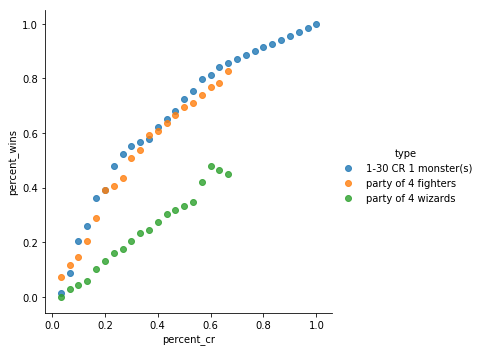

In [16]:
mixed_to30 = pandas.read_csv('data/gen/characters_to30monsters_100.csv')
plot_correl_df(mixed_to30,'cr',subtitle='party of 4 characters and 1-30 CR 1 monsters')